In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
import subprocess
plt.rc('text', usetex=True)

In [93]:
#os.system('cd .')
os.system('ls')

0

In [82]:
# Constants (currently set for Earth vals)

Tinit = 10 # C
Tvar = 12 # C
Tbottom = 11 # C

# Diffusion constant (https://www.nature.com/articles/nature07818)
alpha = 0.0864 # m^2 / day

# times 
tyear = 365 # d
ti = 0 # d
tf = 5*tyear # d
dt = 1 # d

# Depth and width
D = 20 # m
Nd = 50
W = 4e6 # m
Nw = 100
ad = D/Nd
aw = W/Nw

In [83]:
def get_grid(mx, my, mz, Lx,Ly,Lz):
    #print('mx,my,mz = ',mx,my,mz)
    ix, iy, iz = Lx*np.linspace(0,1,mx), Ly*np.linspace(0,1,my), Lz*np.linspace(0,1,mz)
    x, y, z = np.meshgrid(ix,iy,iz, indexing='ij')
    #print('ix', ix), print('iy', iy), print('iz', iz)
    return x,y,z

def plot_grid(x,y,z,T, filename):
    def plot_boundary_only(x,y,z,T):
        #mx, my, mz = x.shape
        x[1:-1, 1:-1, 1:-1],y[1:-1, 1:-1, 1:-1],z[1:-1, 1:-1, 1:-1],T[1:-1, 1:-1, 1:-1] = np.nan, np.nan, np.nan, np.nan \
                #This removes interior because we cannot see it anyway? reduces time to plot
        return x,y,z,T
    
    x,y,z,T = plot_boundary_only(x,y,z,T)   
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x,y,z, c=T.reshape(-1), s=150, cmap=plt.inferno())
    cbar = fig.colorbar(img, orientation='horizontal', fraction=0.047, pad=0.15, aspect=15)
    plt.tick_params(axis='both', which='major', labelsize=18)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'Temperature ($^oC$)', size = 22)
    ax.set_ylabel('Y (km)', fontsize = 20)
    ax.set_xlabel('X (km)', rotation=0, fontsize = 20)
    ax.set_zlabel('Depth from surface (km)', rotation=0, fontsize = 20)
    ax.invert_zaxis()
    plt.tight_layout()
    #plt.savefig('tempevolution_plots/temp%s.png'%count)
    plt.savefig(filename)
    plt.show()
    
def init_T(x,y,z, T_3d):
    #print('size of y = ', np.shape(y))
    T = np.zeros_like(x)
    #print('Size of T = ',np.shape(T))
    T = T_3d
    return T


In [84]:
def show_plot(crust, t):
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    im = ax.imshow(crust, vmin=0, vmax=20, cmap = 'inferno', aspect = 1 * (Nw/Nd))
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('$\mathrm{Temperature\ [K]}$', rotation=270, labelpad=15)
    ax.set_title('$\mathrm{t = %i\ days}$'%t)
    ax.set_xlabel('$\mathrm{Width}$')
    ax.set_ylabel('$\mathrm{Depth}$')


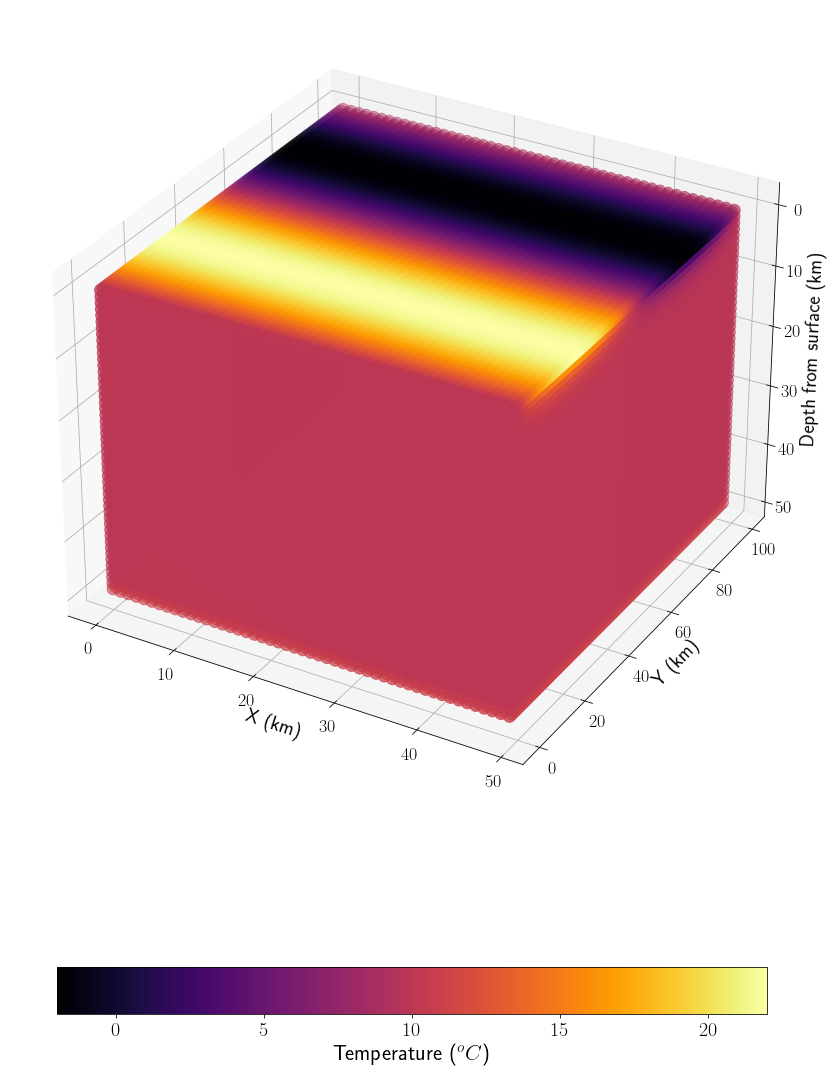

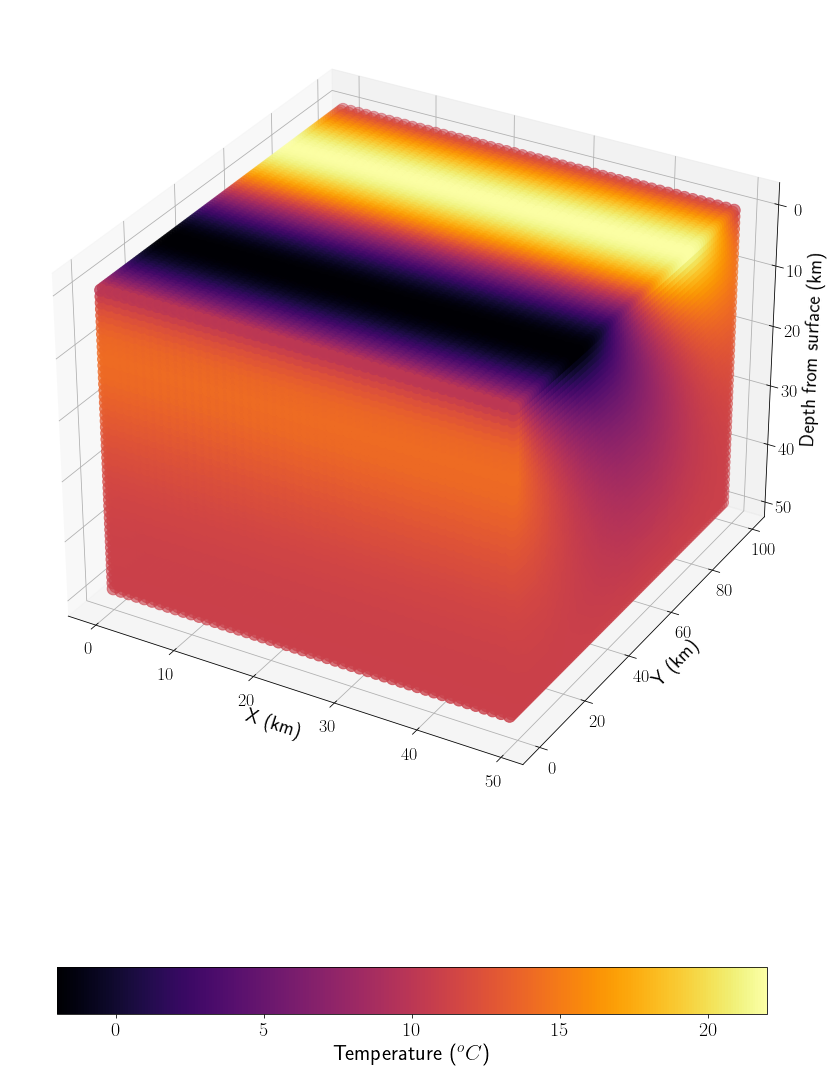

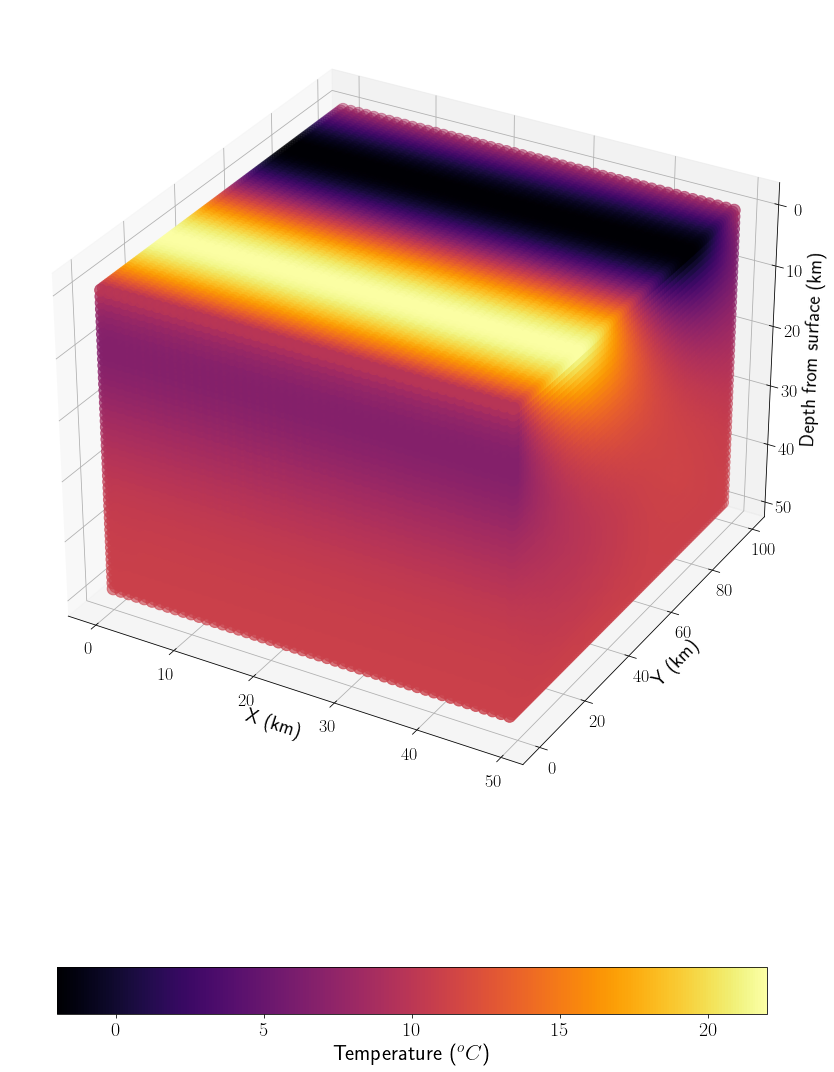

0

In [99]:
# Initialize "crust": 2D array of T = Tinit except at bottom
crust = np.full((Nd,Nw), Tinit, dtype='float')
crust[Nd-1] = Tbottom

count = 0
for t in np.arange(ti, tf+dt, dt):
    
    # periodic heating at surface with phase shift (INCORRECT ON SUB-DAY TIMESCALE)
    phase = np.arange(Nw)/Nw
    crust[0] = Tinit + Tvar*np.sin(2*np.pi*(t/tyear+phase))
    
    # depth (skipping top and bottom to maintain boundaries)
    for i in range(1, Nd-1):
        # width (periodic boundary connecting 0 to Nw)
        for j in range(0, Nw):
            # evolve crust with FTCS approach! (in 2D)
            
            if j == Nw-1: # to avoid overflow at crust[i,j+1]
                crust[i,j] = crust[i,j] + dt*alpha*(
                    (crust[i+1,j] + crust[i-1,j] - 2*crust[i,j])/ad**2 + 
                    (crust[i,0] + crust[i,j-1] - 2*crust[i,j])/aw**2)
            else:
                crust[i,j] = crust[i,j] + dt*alpha*(
                    (crust[i+1,j] + crust[i-1,j] - 2*crust[i,j])/ad**2 + 
                    (crust[i,j+1] + crust[i,j-1] - 2*crust[i,j])/aw**2)
    
    # Show plot

    if t%(tyear//2) == 0:
        crust_3d = np.zeros((Nd,Nw,Nd))

        for i in range(Nd):
            crust_3d[i,:,:] = crust.T
        
        #show_plot(crust, t)
        #plt.show()
        nx, ny, nz = Nd, Nw, Nd
        Lx, Ly, Lz = nx-1, ny-1, nz-1
        x,y,z = get_grid(nx, ny, nz, Lx,Ly,Lz)  # generate a grid with mesh size Δx = Δy = Δz = 1
        T = init_T(x,y,z, crust_3d)
        filename = 'tempevolution_plots/temp'+str(count).zfill(3)+'.png'
        plot_grid(x,y,z,T, filename)
        count += 1

#creating the animation
os.system('ffmpeg -i tempevolution_plots/temp%04d.png  -c:v libx264 -r 8 -pix_fmt yuv420p -vf \
                    "scale=trunc(iw/2)*2:trunc(ih/2)*2" tempevolution_plots/surface_temp.mp4')


In [71]:
#Dufort-Frenkel trial

'''
# Constants (currently set for Earth vals)

Tinit = 10 # C
Tvar = 12 # C
Tbottom = 11 # C

# Diffusion constant (https://www.nature.com/articles/nature07818)
#alpha = 0.0864 # m^2 / day
D = 0.0864

# times 
tyear = 365 # d
ti = 0 # d
tf = 1*tyear # d
dt = 1 # d
tn = int((tf-ti)/dt) #number of timesteps

# Depth and width
d = 20 # m
Nd = 100
W = 4e6 # m
Nw = 100
ad = d/Nd
aw = W/Nw

crust = np.full((tn,Nw,Nd),Tinit, dtype=float)



crust[0,:,0] = Tbottom
crust[0,:,Nd-1] = crust[0,:,Nd-1] * np.sin(2*np.pi*np.linspace(0,1,Nw))

alpha = (2*D*dt)/ad

for n in range(tn):
    print('timestep = ',n)
    for mx in range(Nw-1):
        for my in range(Nd-1):
            #print('mx+1 = ',mx+1)
            if (mx+1 > Nw-1 or my+1 > Nd-1):
                print('Edge')
                crust[n,mx,my]  =  (((1-alpha) / (1+alpha)) * crust[n-2,mx,my])  + \
                                        ((alpha / (1+alpha)) * ( crust[n-1,0,my] + crust[n-1,mx-1,my] + \
                                                    crust[n-1,mx,0] + crust[n-1,mx,my-1] ))
            else:    
                #print('mx, my, n = ',mx,my,n)
                crust[n,mx,my]  =  (((1-alpha) / (1+alpha)) * crust[n-2,mx+1,my])  + \
                                        ((alpha / (1+alpha)) * ( crust[n-1,mx,my] + crust[n-1,mx-1,my] + \
                                                    crust[n-1,mx,my+1] + crust[n-1,mx,my-1] ))
            
         
plt.figure(figsize=(6,4), dpi = 120)
plt.imshow(crust[0].T, origin='lower')
plt.colorbar()

'''

"\ncrust[0,:,0] = Tbottom\ncrust[0,:,Nd-1] = crust[0,:,Nd-1] * np.sin(2*np.pi*np.linspace(0,1,Nw))\n\nalpha = (2*D*dt)/ad\n\nfor n in range(tn):\n    print('timestep = ',n)\n    for mx in range(Nw-1):\n        for my in range(Nd-1):\n            #print('mx+1 = ',mx+1)\n            if (mx+1 > Nw-1 or my+1 > Nd-1):\n                print('Edge')\n                crust[n,mx,my]  =  (((1-alpha) / (1+alpha)) * crust[n-2,mx,my])  +                                         ((alpha / (1+alpha)) * ( crust[n-1,0,my] + crust[n-1,mx-1,my] +                                                     crust[n-1,mx,0] + crust[n-1,mx,my-1] ))\n            else:    \n                #print('mx, my, n = ',mx,my,n)\n                crust[n,mx,my]  =  (((1-alpha) / (1+alpha)) * crust[n-2,mx+1,my])  +                                         ((alpha / (1+alpha)) * ( crust[n-1,mx,my] + crust[n-1,mx-1,my] +                                                     crust[n-1,mx,my+1] + crust[n-1,mx,my-1] ))\n            \n  

In [ ]:
crust_3d[3]